In [34]:
import torch
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
import pandas as pd
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torchtext import data
from torchtext.vocab import Vocab
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import random
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

torch.cuda.is_available()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [35]:
# !pip install transformers

In [36]:
import io
import pandas as pd
df = pd.read_csv('drive/MyDrive/preprocessed_sub_and_body.csv')
df["text"] = df["text"].astype(str)
df['label'] = df['label'].astype(int)
df.head()

Unnamed: 0  label                                         text
0           0      0  fw: june 29 -- bna, inc. daily labor report
1           1      0                           ngx failover plan.
2           2      0                            re: intranet site
3           3      0         fw: ena upstream company information
4           4      0                          new master physical

In [ ]:
df["length"] = df["text"].apply(len)

In [38]:
df['length'].describe()

count    11448.000000
mean       891.971960
std       2101.099586
min          1.000000
25%         35.000000
50%         93.000000
75%        937.000000
max      29191.000000
Name: length, dtype: float64

In [39]:
df = df[df['length'] < 3000]
df['length'].describe()

count    10706.000000
mean       472.950121
std        654.607769
min          1.000000
25%         34.000000
50%         66.000000
75%        759.000000
max       2998.000000
Name: length, dtype: float64

In [40]:
!pip install torchtext==0.6.0

In [41]:
# drop unnecessary columns
df = df[["text", "label"]]

# save preprocessed data to a CSV file
df.to_csv("preprocessed_cleaned.csv", index=False)

# Field is standard column, LabelField is label column
# use spacy as tokenizer
TEXT = data.Field(
    tokenize="spacy",
    tokenizer_language="en_core_web_sm",
    lower=True,
    include_lengths=True,
    batch_first=True,
)
LABEL = data.LabelField(
    dtype=torch.float, sequential=False, use_vocab=False, batch_first=True
)

# create dataset and split into train, val and test
train_data, val_data, test_data = data.TabularDataset.splits(
    path="preprocessed_cleaned.csv",
    format="csv",
    fields=[("Text", TEXT), ("Label", LABEL)],
    split_ratio=[0.8, 0.1, 0.1],
    skip_header=True,
    random_state=random.seed(42),
)

# build vocabulary, min word frequency is 5
TEXT.build_vocab(train_data, max_size=10000, min_freq=5)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [42]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout1, dropout2):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(hidden_dim* 2, 20)
        self.dropout2 = nn.Dropout(dropout2)
        self.fc2 = nn.Linear(20, output_dim)  # multiply hidden_dim by 2
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, x_lengths):
        embedded = self.embedding(x)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, x_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden contains both forward and backward states for the last layer
        lstm_out = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        lstm_out = self.dropout1(lstm_out)
        fc1_out = self.fc1(lstm_out)
        fc1_out = self.dropout2(fc1_out)
        fc2_out = self.fc2(fc1_out)
        output = self.sigmoid(fc2_out)
        return output


In [43]:
# hyperparameters grid
embedding_dims = [32, 64]
hidden_dims = [100, 128]
learning_rates = [0.01, 0.001]
batch_sizes = [64, 128]
dropout_rates = [0.3, 0.4]
n_epochs = 10

best_model = None
best_val_loss = float('inf')
results = []


In [44]:
from tqdm.auto import tqdm
import itertools
import torch.optim as optim

# BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# grid search
for embedding_dim, hidden_dim, lr, batch_size, dropout1, dropout2 in itertools.product(
        embedding_dims, hidden_dims, learning_rates, batch_sizes, dropout_rates, dropout_rates):

      # create iterators
      train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
          (train_data, val_data, test_data),
          batch_size=batch_size,
          sort_key=lambda x: len(x.body),
          sort_within_batch=True,
          device=device
      )


      lstm_model = BiLSTMModel(len(TEXT.vocab), embedding_dim, hidden_dim, 1, dropout1, dropout2).to(device)
      criterion = nn.BCELoss()
      criterion = criterion.to(device)
      optimizer = optim.Adam(lstm_model.parameters(),lr=lr)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

      # early stopping criteria
      early_stopping_patience = 3
      best_epoch_val_loss = float('inf')
      epochs_no_improve = 0

      # training loop
      train_losses = []
      val_losses = []

      for epoch in range(n_epochs):

          epoch_train_loss = 0
          lstm_model.train()

          with tqdm(train_iterator, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            for batch in tepoch:
                sequences, lengths = batch.body
                labels = batch.label
                optimizer.zero_grad()
                predictions = lstm_model(sequences, lengths).squeeze()
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

          train_losses.append(epoch_train_loss / len(train_iterator))

          print(f"\nTraining epoch {epoch + 1} loss: ", epoch_train_loss)
          # TRAINING BLOCK ENDS
          print("Training complete!")


          # Validation
          lstm_model.eval()
          epoch_val_loss = 0
          val_preds = []
          val_labels = []

          with torch.no_grad():
              for batch in val_iterator:
                  sequences, lengths = batch.body
                  labels = batch.label
                  predictions = lstm_model(sequences, lengths).squeeze()
                  loss = criterion(predictions, labels)
                  epoch_val_loss += loss.item()
                  val_preds.extend(predictions.cpu().numpy())
                  val_labels.extend(labels.cpu().numpy())

          val_losses.append(epoch_val_loss / len(val_iterator))

          print(f"\nValidation epoch {epoch + 1} loss: {epoch_val_loss}")

          # early stopping
          if epoch_val_loss < best_epoch_val_loss:
              best_epoch_val_loss = epoch_val_loss
              epochs_no_improve = 0
          else:
              epochs_no_improve += 1
              if epochs_no_improve >= early_stopping_patience:
                  print(f"Early stopping triggered at epoch {epoch+1}")
                  break

          # check if current model is the best
          if val_losses[-1] < best_val_loss:
              best_val_loss = val_losses[-1]
              best_model = lstm_model

          # record the results for this hyperparameter configuration
          results.append({
              'embedding_dim': embedding_dim,
              'hidden_dim': hidden_dim,
              'lr': lr,
              'batch_size': batch_size,
              'dropout1': dropout1,
              'dropout2': dropout2,
              'n_epochs': n_epochs,
              'train_loss': train_losses[-1],
              'val_loss': val_losses[-1]
          })

best_hyperparams = min(results, key=lambda x: x['val_loss'])
print("Best Hyperparameters:")
print(best_hyperparams)


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  48.5526310056448
Training complete!

Validation epoch 1 loss: 3.423389211297035


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  20.262138156220317
Training complete!

Validation epoch 2 loss: 2.857655171304941


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  11.871120713185519
Training complete!

Validation epoch 3 loss: 2.6867711171507835


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.732650976337027
Training complete!

Validation epoch 4 loss: 2.433953977189958


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.8997827497514663
Training complete!

Validation epoch 5 loss: 3.761055528448196


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.9311724641465844
Training complete!

Validation epoch 6 loss: 4.093849011595012


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  2.1215556956603905
Training complete!

Validation epoch 7 loss: 4.5128929909842554
Early stopping triggered at epoch 7


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  50.85467132925987
Training complete!

Validation epoch 1 loss: 3.8753261864185333


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  20.61357998754829
Training complete!

Validation epoch 2 loss: 3.142030641436577


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  11.336737056262791
Training complete!

Validation epoch 3 loss: 2.7573182974010706


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.916910534913768
Training complete!

Validation epoch 4 loss: 2.643577695824206


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.5261663853307255
Training complete!

Validation epoch 5 loss: 3.586280854069628


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.3314252042910084
Training complete!

Validation epoch 6 loss: 5.196772096932136


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  2.0536918804587003
Training complete!

Validation epoch 7 loss: 3.7800141447223723
Early stopping triggered at epoch 7


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  51.30461595952511
Training complete!

Validation epoch 1 loss: 3.911385864019394


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.034256106242537
Training complete!

Validation epoch 2 loss: 2.7130880504846573


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  12.544932125601918
Training complete!

Validation epoch 3 loss: 2.6890894882380962


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.192562073701993
Training complete!

Validation epoch 4 loss: 2.5028273379430175


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.970731247609365
Training complete!

Validation epoch 5 loss: 2.983915526419878


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.2230081598609104
Training complete!

Validation epoch 6 loss: 3.32690855441615


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  2.457352772719787
Training complete!

Validation epoch 7 loss: 3.3749278457835317
Early stopping triggered at epoch 7


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  57.4374221265316
Training complete!

Validation epoch 1 loss: 4.691925138235092


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.7775153554976
Training complete!

Validation epoch 2 loss: 3.03713221848011


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  13.426984421908855
Training complete!

Validation epoch 3 loss: 2.6848319694399834


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.863689519115724
Training complete!

Validation epoch 4 loss: 2.7923538964241743


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.546413605217822
Training complete!

Validation epoch 5 loss: 3.0745084141381085


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  5.183006649604067
Training complete!

Validation epoch 6 loss: 3.7117617218755186
Early stopping triggered at epoch 6


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  26.03127248585224
Training complete!

Validation epoch 1 loss: 2.3607579171657562


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  12.327540077269077
Training complete!

Validation epoch 2 loss: 1.7944602444767952


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  6.861078852787614
Training complete!

Validation epoch 3 loss: 1.9147982150316238


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.496682350989431
Training complete!

Validation epoch 4 loss: 1.5866992324590683


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.1580669082177337
Training complete!

Validation epoch 5 loss: 2.375112257897854


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.244548162270803
Training complete!

Validation epoch 6 loss: 1.859112910926342


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.6712231891506235
Training complete!

Validation epoch 7 loss: 2.54085411131382
Early stopping triggered at epoch 7


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  25.82432745397091
Training complete!

Validation epoch 1 loss: 7.611344903707504


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  15.837339147925377
Training complete!

Validation epoch 2 loss: 1.8370450362563133


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.22471696510911
Training complete!

Validation epoch 3 loss: 1.432511541992426


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.523903552442789
Training complete!

Validation epoch 4 loss: 1.4294975697994232


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.7532649873755872
Training complete!

Validation epoch 5 loss: 1.474797211587429


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.7742522910411935
Training complete!

Validation epoch 6 loss: 1.6093980055302382


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.3359612606291194
Training complete!

Validation epoch 7 loss: 2.439148597419262
Early stopping triggered at epoch 7


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  28.644469305872917
Training complete!

Validation epoch 1 loss: 2.787920504808426


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  13.877277202904224
Training complete!

Validation epoch 2 loss: 1.7538258731365204


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  7.462143540382385
Training complete!

Validation epoch 3 loss: 1.6240432187914848


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.224561899900436
Training complete!

Validation epoch 4 loss: 1.790368426591158


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.3573637003428303
Training complete!

Validation epoch 5 loss: 1.6893094293773174


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.0762595719425008
Training complete!

Validation epoch 6 loss: 1.9722945764660835
Early stopping triggered at epoch 6


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  28.079817160964012
Training complete!

Validation epoch 1 loss: 3.447019547224045


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  14.83772249892354
Training complete!

Validation epoch 2 loss: 1.8792543485760689


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.781415075063705
Training complete!

Validation epoch 3 loss: 2.047327660024166


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.290502166375518
Training complete!

Validation epoch 4 loss: 1.6414238139986992


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.8721850796137005
Training complete!

Validation epoch 5 loss: 1.7137024700641632


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.644126929604681
Training complete!

Validation epoch 6 loss: 1.7067760601639748


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.9855024937496637
Training complete!

Validation epoch 7 loss: 2.1567272767424583
Early stopping triggered at epoch 7


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  60.18573872745037
Training complete!

Validation epoch 1 loss: 5.327786922454834


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  39.052216939628124
Training complete!

Validation epoch 2 loss: 5.658134907484055


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  34.8087340220809
Training complete!

Validation epoch 3 loss: 4.226466611027718


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  26.558287685737014
Training complete!

Validation epoch 4 loss: 3.9372518435120583


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  22.405530515126884
Training complete!

Validation epoch 5 loss: 3.913902126252651


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  18.713755011558533
Training complete!

Validation epoch 6 loss: 3.4112745001912117


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  15.719014626927674
Training complete!

Validation epoch 7 loss: 4.0299132987856865


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  13.470058742444962
Training complete!

Validation epoch 8 loss: 3.3532908633351326


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 9 loss:  10.647210632101633
Training complete!

Validation epoch 9 loss: 4.560098275542259


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 10 loss:  9.559869941440411
Training complete!

Validation epoch 10 loss: 4.822133533656597


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  64.81317563354969
Training complete!

Validation epoch 1 loss: 6.616390734910965


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  42.34532333910465
Training complete!

Validation epoch 2 loss: 4.921599313616753


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  31.854626102373004
Training complete!

Validation epoch 3 loss: 4.376945346593857


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  26.040497628971934
Training complete!

Validation epoch 4 loss: 3.8742357939481735


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  21.474820397794247
Training complete!

Validation epoch 5 loss: 4.061925105750561


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  17.946688988246024
Training complete!

Validation epoch 6 loss: 3.547950220759958


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  16.73144424147904
Training complete!

Validation epoch 7 loss: 3.7666675820946693


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  16.37058572936803
Training complete!

Validation epoch 8 loss: 3.985113024711609


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 9 loss:  12.35094523546286
Training complete!

Validation epoch 9 loss: 3.8043966963887215
Early stopping triggered at epoch 9


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  63.96470183134079
Training complete!

Validation epoch 1 loss: 5.65545953810215


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  39.16419254988432
Training complete!

Validation epoch 2 loss: 4.618013262748718


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  30.665171422064304
Training complete!

Validation epoch 3 loss: 4.173261918127537


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  27.99746980704367
Training complete!

Validation epoch 4 loss: 5.8091800063848495


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  23.79635291872546
Training complete!

Validation epoch 5 loss: 3.692404717206955


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  18.22485180804506
Training complete!

Validation epoch 6 loss: 3.8680368177592754


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  22.629672194831073
Training complete!

Validation epoch 7 loss: 3.826117344200611


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  14.465697712032124
Training complete!

Validation epoch 8 loss: 3.853046737611294
Early stopping triggered at epoch 8


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  64.8727947473526
Training complete!

Validation epoch 1 loss: 5.48965984582901


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  40.08500147610903
Training complete!

Validation epoch 2 loss: 4.793645799160004


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  32.101431518793106
Training complete!

Validation epoch 3 loss: 4.021611258387566


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  26.72059086430818
Training complete!

Validation epoch 4 loss: 3.944002155214548


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  22.768323197960854
Training complete!

Validation epoch 5 loss: 3.4289522245526314


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  19.651386274024844
Training complete!

Validation epoch 6 loss: 3.499664530158043


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  15.81465238519013
Training complete!

Validation epoch 7 loss: 3.264735440723598


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  13.162665767245926
Training complete!

Validation epoch 8 loss: 3.240622231736779


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 9 loss:  10.763935880677309
Training complete!

Validation epoch 9 loss: 3.68660868704319


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 10 loss:  9.202964634663658
Training complete!

Validation epoch 10 loss: 3.452019026502967


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  34.92862078547478
Training complete!

Validation epoch 1 loss: 3.608866348862648


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.44562818109989
Training complete!

Validation epoch 2 loss: 3.000229001045227


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  19.010951980948448
Training complete!

Validation epoch 3 loss: 2.7149820625782013


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  16.17481392621994
Training complete!

Validation epoch 4 loss: 2.431428477168083


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  14.645883277058601
Training complete!

Validation epoch 5 loss: 2.3704102486371994


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  12.333622606471181
Training complete!

Validation epoch 6 loss: 2.256371222436428


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  10.62840928696096
Training complete!

Validation epoch 7 loss: 2.2312960363924503


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  9.039529255591333
Training complete!

Validation epoch 8 loss: 2.1260509714484215


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  7.87416579388082
Training complete!

Validation epoch 9 loss: 2.305664472281933


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.263958495575935
Training complete!

Validation epoch 10 loss: 2.0861885845661163


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.95466420054436
Training complete!

Validation epoch 1 loss: 4.509967863559723


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.474845364689827
Training complete!

Validation epoch 2 loss: 2.9991492927074432


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  19.73556910455227
Training complete!

Validation epoch 3 loss: 2.494104579091072


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  16.540104806423187
Training complete!

Validation epoch 4 loss: 2.259510323405266


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  14.382502999156713
Training complete!

Validation epoch 5 loss: 2.0147427171468735


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  12.091601753607392
Training complete!

Validation epoch 6 loss: 1.9160354435443878


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  10.349712958559394
Training complete!

Validation epoch 7 loss: 1.8526030741631985


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  8.788815438747406
Training complete!

Validation epoch 8 loss: 1.8612675294280052


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  8.565520860254765
Training complete!

Validation epoch 9 loss: 2.406725361943245


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  7.3915831502527
Training complete!

Validation epoch 10 loss: 2.1871331483125687
Early stopping triggered at epoch 10


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  37.45700663328171
Training complete!

Validation epoch 1 loss: 3.7247587144374847


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.601830914616585
Training complete!

Validation epoch 2 loss: 2.9201906323432922


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  22.625953823328018
Training complete!

Validation epoch 3 loss: 2.7934214621782303


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.334755428135395
Training complete!

Validation epoch 4 loss: 2.5654293298721313


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.869750034064054
Training complete!

Validation epoch 5 loss: 2.283531069755554


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  13.943865679204464
Training complete!

Validation epoch 6 loss: 2.1494485437870026


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  13.755581256002188
Training complete!

Validation epoch 7 loss: 2.0806458592414856


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  12.045618630945683
Training complete!

Validation epoch 8 loss: 1.9473248273134232


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.453072559088469
Training complete!

Validation epoch 9 loss: 1.9242533817887306


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.213354288600385
Training complete!

Validation epoch 10 loss: 1.793705765157938


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.591801673173904
Training complete!

Validation epoch 1 loss: 3.4364219456911087


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.887296840548515
Training complete!

Validation epoch 2 loss: 2.7038361728191376


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  19.251910157501698
Training complete!

Validation epoch 3 loss: 2.457400932908058


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  15.667339771986008
Training complete!

Validation epoch 4 loss: 3.055406540632248


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  14.684266556054354
Training complete!

Validation epoch 5 loss: 2.1583422794938087


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  12.31407442688942
Training complete!

Validation epoch 6 loss: 2.034674845635891


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  10.582351827993989
Training complete!

Validation epoch 7 loss: 2.121119938790798


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  9.449567353352904
Training complete!

Validation epoch 8 loss: 2.0043120235204697


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  7.925565998069942
Training complete!

Validation epoch 9 loss: 2.0962976440787315


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  7.319901640992612
Training complete!

Validation epoch 10 loss: 2.151695169508457


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  48.838498160243034
Training complete!

Validation epoch 1 loss: 3.5594438053667545


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.409810880199075
Training complete!

Validation epoch 2 loss: 2.743339339271188


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  11.30643140617758
Training complete!

Validation epoch 3 loss: 2.611386289820075


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.183080561226234
Training complete!

Validation epoch 4 loss: 3.034927180968225


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.816522009197797
Training complete!

Validation epoch 5 loss: 3.2442603390663862


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  13.04120069000055
Training complete!

Validation epoch 6 loss: 3.2502707168459892
Early stopping triggered at epoch 6


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  50.50171799212694
Training complete!

Validation epoch 1 loss: 3.463169127702713


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  22.901185797527432
Training complete!

Validation epoch 2 loss: 2.750171273946762


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  12.73863407666795
Training complete!

Validation epoch 3 loss: 2.8311304580420256


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.905595295364037
Training complete!

Validation epoch 4 loss: 3.12143451301381


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.966397917465656
Training complete!

Validation epoch 5 loss: 3.8418704064097255
Early stopping triggered at epoch 5


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  46.0975531116128
Training complete!

Validation epoch 1 loss: 3.636010844260454


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.271239237859845
Training complete!

Validation epoch 2 loss: 2.8526564426720142


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  11.578654917655513
Training complete!

Validation epoch 3 loss: 2.5090581234544516


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.779214841459179
Training complete!

Validation epoch 4 loss: 2.591442748904228


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.433958700967196
Training complete!

Validation epoch 5 loss: 3.7730132029391825


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.5244561037125095
Training complete!

Validation epoch 6 loss: 6.478375512640923
Early stopping triggered at epoch 6


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  47.455587923526764
Training complete!

Validation epoch 1 loss: 4.377821132540703


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  22.78782013244927
Training complete!

Validation epoch 2 loss: 2.8170042894780636


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  15.06699702469632
Training complete!

Validation epoch 3 loss: 2.945397898554802


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.5681470655836165
Training complete!

Validation epoch 4 loss: 3.4727881802245975


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.2547756048006704
Training complete!

Validation epoch 5 loss: 4.262408008988132
Early stopping triggered at epoch 5


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  28.2960202768445
Training complete!

Validation epoch 1 loss: 5.147796303033829


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  14.803194433450699
Training complete!

Validation epoch 2 loss: 2.184983804821968


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.748399691656232
Training complete!

Validation epoch 3 loss: 1.7807204574346542


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.574450836516917
Training complete!

Validation epoch 4 loss: 1.7833821475505829


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.6667253498453647
Training complete!

Validation epoch 5 loss: 2.4663442820310593


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.6968086563574616
Training complete!

Validation epoch 6 loss: 1.9816285632550716
Early stopping triggered at epoch 6


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  29.56116296350956
Training complete!

Validation epoch 1 loss: 2.4994660019874573


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  13.542353317141533
Training complete!

Validation epoch 2 loss: 1.8101068288087845


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  7.137329173274338
Training complete!

Validation epoch 3 loss: 1.7120063044130802


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  3.681328480364755
Training complete!

Validation epoch 4 loss: 1.8622954040765762


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.5341845548246056
Training complete!

Validation epoch 5 loss: 2.4397657811641693


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.1250324516295223
Training complete!

Validation epoch 6 loss: 2.249935008585453
Early stopping triggered at epoch 6


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  33.2321774661541
Training complete!

Validation epoch 1 loss: 2.632532685995102


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  13.993564363569021
Training complete!

Validation epoch 2 loss: 2.223449468612671


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.736413929611444
Training complete!

Validation epoch 3 loss: 1.7782375663518906


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.645877732895315
Training complete!

Validation epoch 4 loss: 1.6371434405446053


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.0385495556984097
Training complete!

Validation epoch 5 loss: 2.028670471161604


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.8202059245086275
Training complete!

Validation epoch 6 loss: 2.3161578476428986


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.3711347677890444
Training complete!

Validation epoch 7 loss: 2.5678587071597576
Early stopping triggered at epoch 7


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  30.186756491661072
Training complete!

Validation epoch 1 loss: 2.277513138949871


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  14.16492136195302
Training complete!

Validation epoch 2 loss: 1.8642819672822952


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  7.960604805499315
Training complete!

Validation epoch 3 loss: 1.6874049305915833


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.586131051648408
Training complete!

Validation epoch 4 loss: 1.788576703518629


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.344744124333374
Training complete!

Validation epoch 5 loss: 2.1702523306012154


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.8880817849276355
Training complete!

Validation epoch 6 loss: 2.6260109320282936
Early stopping triggered at epoch 6


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  67.16087594628334
Training complete!

Validation epoch 1 loss: 6.50373749434948


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  42.12742932140827
Training complete!

Validation epoch 2 loss: 4.7763819471001625


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  32.25631143525243
Training complete!

Validation epoch 3 loss: 4.244832590222359


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  26.250689011067152
Training complete!

Validation epoch 4 loss: 3.5848107039928436


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  22.82377798575908
Training complete!

Validation epoch 5 loss: 3.566647879779339


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  20.637839085422456
Training complete!

Validation epoch 6 loss: 3.2852488309144974


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  15.85410378035158
Training complete!

Validation epoch 7 loss: 3.331978853791952


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  13.465339538874105
Training complete!

Validation epoch 8 loss: 3.2183152278885245


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 9 loss:  11.073451976495562
Training complete!

Validation epoch 9 loss: 3.28506519831717


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 10 loss:  9.007107236771844
Training complete!

Validation epoch 10 loss: 3.703263495117426


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  64.27994114160538
Training complete!

Validation epoch 1 loss: 6.02169032394886


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  41.14524592459202
Training complete!

Validation epoch 2 loss: 4.882006287574768


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  32.94212577864528
Training complete!

Validation epoch 3 loss: 4.205802671611309


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  26.27290684916079
Training complete!

Validation epoch 4 loss: 4.523541823029518


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  21.877800528891385
Training complete!

Validation epoch 5 loss: 3.633657332509756


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  20.17638196540065
Training complete!

Validation epoch 6 loss: 4.113709881901741


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  16.850361835677177
Training complete!

Validation epoch 7 loss: 3.636938590556383


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  12.347028554591816
Training complete!

Validation epoch 8 loss: 3.7202704660594463
Early stopping triggered at epoch 8


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  65.18034154176712
Training complete!

Validation epoch 1 loss: 5.959509015083313


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  44.70663097500801
Training complete!

Validation epoch 2 loss: 5.037743732333183


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  35.00913292914629
Training complete!

Validation epoch 3 loss: 4.603981748223305


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  30.745426639914513
Training complete!

Validation epoch 4 loss: 4.137959823012352


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  25.461166279390454
Training complete!

Validation epoch 5 loss: 3.6736425291746855


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  20.69937069993466
Training complete!

Validation epoch 6 loss: 3.8180218571797013


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  18.58873317250982
Training complete!

Validation epoch 7 loss: 3.7823779843747616


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  16.6563344434835
Training complete!

Validation epoch 8 loss: 3.7910590269602835
Early stopping triggered at epoch 8


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  66.26149907708168
Training complete!

Validation epoch 1 loss: 6.488909006118774


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  43.71103095263243
Training complete!

Validation epoch 2 loss: 5.116004526615143


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  33.530200615525246
Training complete!

Validation epoch 3 loss: 4.418279230594635


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  27.817316841334105
Training complete!

Validation epoch 4 loss: 4.120721139013767


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  22.485305395908654
Training complete!

Validation epoch 5 loss: 3.9297026097774506


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  18.399413084611297
Training complete!

Validation epoch 6 loss: 3.6972092911601067


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  15.643753875279799
Training complete!

Validation epoch 7 loss: 4.113051936030388


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  15.165133262518793
Training complete!

Validation epoch 8 loss: 4.19010367244482


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 9 loss:  13.02115404093638
Training complete!

Validation epoch 9 loss: 4.019569829106331
Early stopping triggered at epoch 9


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  35.855627447366714
Training complete!

Validation epoch 1 loss: 3.5880696773529053


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.0084308385849
Training complete!

Validation epoch 2 loss: 3.197651982307434


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  19.37916538864374
Training complete!

Validation epoch 3 loss: 2.5882824808359146


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  16.095155768096447
Training complete!

Validation epoch 4 loss: 2.3063956052064896


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.015068002045155
Training complete!

Validation epoch 5 loss: 2.2792127057909966


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  12.884637270122766
Training complete!

Validation epoch 6 loss: 2.2021427527070045


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  11.128353364765644
Training complete!

Validation epoch 7 loss: 1.9719904586672783


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  9.424843322485685
Training complete!

Validation epoch 8 loss: 1.997246339917183


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  7.876090958714485
Training complete!

Validation epoch 9 loss: 1.8976400941610336


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  6.779891786631197
Training complete!

Validation epoch 10 loss: 2.013977125287056


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  35.381859451532364
Training complete!

Validation epoch 1 loss: 3.30243843793869


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.977074071764946
Training complete!

Validation epoch 2 loss: 2.812898188829422


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  18.75804229453206
Training complete!

Validation epoch 3 loss: 2.489098832011223


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  15.72257979772985
Training complete!

Validation epoch 4 loss: 2.3719529435038567


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  14.518016297370195
Training complete!

Validation epoch 5 loss: 2.294868789613247


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  13.029958087950945
Training complete!

Validation epoch 6 loss: 2.1049891114234924


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  10.683568082749844
Training complete!

Validation epoch 7 loss: 1.968672413378954


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  9.420186006464064
Training complete!

Validation epoch 8 loss: 1.942964069545269


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  8.4002461056225
Training complete!

Validation epoch 9 loss: 2.0097510553896427


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  7.08585011260584
Training complete!

Validation epoch 10 loss: 1.8338112961500883


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  35.5354887843132
Training complete!

Validation epoch 1 loss: 3.817012310028076


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  24.105701208114624
Training complete!

Validation epoch 2 loss: 3.0055082738399506


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  18.974702179431915
Training complete!

Validation epoch 3 loss: 2.7014368921518326


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  15.454470485448837
Training complete!

Validation epoch 4 loss: 2.5240416675806046


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  14.207016445696354
Training complete!

Validation epoch 5 loss: 2.2973090410232544


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  12.776078397408128
Training complete!

Validation epoch 6 loss: 2.261900767683983


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  10.678515769541264
Training complete!

Validation epoch 7 loss: 2.1958991810679436


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  9.146377446129918
Training complete!

Validation epoch 8 loss: 1.987905114889145


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  7.5760937868617475
Training complete!

Validation epoch 9 loss: 2.0296230129897594


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  6.47408645786345
Training complete!

Validation epoch 10 loss: 2.125368505716324


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  37.38098740577698
Training complete!

Validation epoch 1 loss: 3.754096269607544


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  24.86125674843788
Training complete!

Validation epoch 2 loss: 3.3216219544410706


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  20.475121945142746
Training complete!

Validation epoch 3 loss: 2.7241044640541077


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  16.858441419899464
Training complete!

Validation epoch 4 loss: 2.6608980149030685


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  14.443392012268305
Training complete!

Validation epoch 5 loss: 2.4246338605880737


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  12.809420801699162
Training complete!

Validation epoch 6 loss: 2.2423561364412308


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  11.25594243966043
Training complete!

Validation epoch 7 loss: 2.096184656023979


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  10.190514672547579
Training complete!

Validation epoch 8 loss: 2.264210782945156


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.40223226416856
Training complete!

Validation epoch 9 loss: 1.962749496102333


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.249142402783036
Training complete!

Validation epoch 10 loss: 2.1243329383432865


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  42.624980233609676
Training complete!

Validation epoch 1 loss: 3.7523166239261627


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  16.611621991731226
Training complete!

Validation epoch 2 loss: 2.4741296730935574


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.47675858202274
Training complete!

Validation epoch 3 loss: 2.5922584729269147


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.402507567661814
Training complete!

Validation epoch 4 loss: 3.2529606241732836


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.421964538436441
Training complete!

Validation epoch 5 loss: 5.284790003206581
Early stopping triggered at epoch 5


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  45.35163725912571
Training complete!

Validation epoch 1 loss: 3.4291094467043877


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  17.561434188857675
Training complete!

Validation epoch 2 loss: 2.733675856143236


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.652335829334334
Training complete!

Validation epoch 3 loss: 3.391046851873398


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.122461983221001
Training complete!

Validation epoch 4 loss: 3.6188754327595234


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.0737711129986565
Training complete!

Validation epoch 5 loss: 4.304941087961197
Early stopping triggered at epoch 5


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  43.559253469109535
Training complete!

Validation epoch 1 loss: 2.9825943261384964


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  17.04328899923712
Training complete!

Validation epoch 2 loss: 2.693258300423622


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.669110413175076
Training complete!

Validation epoch 3 loss: 2.8094104672782123


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.979323882202152
Training complete!

Validation epoch 4 loss: 2.58413622318767


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.9736802483384963
Training complete!

Validation epoch 5 loss: 3.5630805019754916


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.9218799499249144
Training complete!

Validation epoch 6 loss: 4.601626229705289


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.9600485210864917
Training complete!

Validation epoch 7 loss: 4.435302845085971
Early stopping triggered at epoch 7


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  42.65265220031142
Training complete!

Validation epoch 1 loss: 3.8136154264211655


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  18.873488180339336
Training complete!

Validation epoch 2 loss: 2.939939923584461


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.871625344152562
Training complete!

Validation epoch 3 loss: 2.68495358992368


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.081666655736626
Training complete!

Validation epoch 4 loss: 3.625135101377964


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.652126772096381
Training complete!

Validation epoch 5 loss: 3.0625373288057745


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.5177119437830697
Training complete!

Validation epoch 6 loss: 3.78798951767385
Early stopping triggered at epoch 6


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  22.762732557952404
Training complete!

Validation epoch 1 loss: 4.47739964723587


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  11.17978211119771
Training complete!

Validation epoch 2 loss: 1.5775525718927383


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  6.356997875496745
Training complete!

Validation epoch 3 loss: 1.3430980145931244


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  2.9554886880796403
Training complete!

Validation epoch 4 loss: 1.4940831735730171


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  1.4655907278356608
Training complete!

Validation epoch 5 loss: 1.8485107086598873


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  0.8858741516050941
Training complete!

Validation epoch 6 loss: 2.4508393686264753
Early stopping triggered at epoch 6


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  23.26312506943941
Training complete!

Validation epoch 1 loss: 1.9833509624004364


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  10.613046064972878
Training complete!

Validation epoch 2 loss: 2.2591025084257126


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  7.852364387363195
Training complete!

Validation epoch 3 loss: 1.541235513985157


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  3.9975406494922936
Training complete!

Validation epoch 4 loss: 1.6090385019779205


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.344729224452749
Training complete!

Validation epoch 5 loss: 1.9893413707613945


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.1287337360408856
Training complete!

Validation epoch 6 loss: 2.0756843350827694
Early stopping triggered at epoch 6


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  24.820591676980257
Training complete!

Validation epoch 1 loss: 2.98020301759243


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  12.115692883729935
Training complete!

Validation epoch 2 loss: 1.5386332049965858


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  6.070705675985664
Training complete!

Validation epoch 3 loss: 1.2614800371229649


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  3.2941939613083377
Training complete!

Validation epoch 4 loss: 1.200167328119278


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  1.6995616896892898
Training complete!

Validation epoch 5 loss: 1.6124013885855675


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.0851836946640105
Training complete!

Validation epoch 6 loss: 1.7529826033860445


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  2.1701983690436464
Training complete!

Validation epoch 7 loss: 1.8478158563375473
Early stopping triggered at epoch 7


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  22.79903305321932
Training complete!

Validation epoch 1 loss: 2.1708527132868767


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  10.704021699726582
Training complete!

Validation epoch 2 loss: 1.4405248388648033


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  5.22963835997507
Training complete!

Validation epoch 3 loss: 1.729593575000763


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  3.190851910680067
Training complete!

Validation epoch 4 loss: 1.5789419934153557


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.462346762418747
Training complete!

Validation epoch 5 loss: 2.035927891731262
Early stopping triggered at epoch 5


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  57.399666249752045
Training complete!

Validation epoch 1 loss: 4.7166482880711555


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  32.74028419330716
Training complete!

Validation epoch 2 loss: 4.401296593248844


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  23.168752026744187
Training complete!

Validation epoch 3 loss: 3.330526739358902


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  17.632824881002307
Training complete!

Validation epoch 4 loss: 3.3846730403602123


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  14.807377230143175
Training complete!

Validation epoch 5 loss: 2.8564583277329803


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  9.066273558710236
Training complete!

Validation epoch 6 loss: 3.1298567662015557


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.536468988837441
Training complete!

Validation epoch 7 loss: 3.1491078205872327


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.0273495482579165
Training complete!

Validation epoch 8 loss: 3.945031586335972
Early stopping triggered at epoch 8


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  59.568576991558075
Training complete!

Validation epoch 1 loss: 4.577412486076355


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  32.98041008412838
Training complete!

Validation epoch 2 loss: 3.7494971938431263


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  23.988596238195896
Training complete!

Validation epoch 3 loss: 3.3198382891714573


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  18.09615258825943
Training complete!

Validation epoch 4 loss: 3.2550043649971485


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  14.537741320440546
Training complete!

Validation epoch 5 loss: 2.9067881256341934


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  10.209952796576545
Training complete!

Validation epoch 6 loss: 3.009788626804948


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  10.261834076081868
Training complete!

Validation epoch 7 loss: 3.011023996397853


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  6.698461987718474
Training complete!

Validation epoch 8 loss: 3.1802505180239677
Early stopping triggered at epoch 8


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  58.64697037637234
Training complete!

Validation epoch 1 loss: 4.953386202454567


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  33.769819624722004
Training complete!

Validation epoch 2 loss: 4.078867249190807


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  24.832713432610035
Training complete!

Validation epoch 3 loss: 3.4973693937063217


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  20.049693203531206
Training complete!

Validation epoch 4 loss: 3.2355652935802937


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.083092311397195
Training complete!

Validation epoch 5 loss: 3.2014200361445546


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  11.01130651019048
Training complete!

Validation epoch 6 loss: 2.9150334130972624


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  8.065123059379403
Training complete!

Validation epoch 7 loss: 3.7267316058278084


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.866518132024794
Training complete!

Validation epoch 8 loss: 3.30758353281999


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 9 loss:  6.079318163439893
Training complete!

Validation epoch 9 loss: 3.4326749600004405
Early stopping triggered at epoch 9


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  58.649886921048164
Training complete!

Validation epoch 1 loss: 4.930806711316109


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  34.03085804358125
Training complete!

Validation epoch 2 loss: 4.353110432624817


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  26.85430184751749
Training complete!

Validation epoch 3 loss: 4.035243812948465


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  20.57655546674505
Training complete!

Validation epoch 4 loss: 3.5454225623980165


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.896348661975935
Training complete!

Validation epoch 5 loss: 3.5905905663967133


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  13.068993867840618
Training complete!

Validation epoch 6 loss: 3.5212293714284897


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  9.515209086821415
Training complete!

Validation epoch 7 loss: 3.758385910652578


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  7.1094331832428
Training complete!

Validation epoch 8 loss: 4.287963325157762


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 9 loss:  5.0139164591164445
Training complete!

Validation epoch 9 loss: 4.552878142334521
Early stopping triggered at epoch 9


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  32.44389045238495
Training complete!

Validation epoch 1 loss: 3.232392907142639


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.318353682756424
Training complete!

Validation epoch 2 loss: 2.5239341482520103


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  15.11635259911418
Training complete!

Validation epoch 3 loss: 2.154872976243496


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.619683537632227
Training complete!

Validation epoch 4 loss: 1.959658406674862


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  9.828068722039461
Training complete!

Validation epoch 5 loss: 1.768100455403328


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.654336935840547
Training complete!

Validation epoch 6 loss: 1.766306348145008


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  7.169538874179125
Training complete!

Validation epoch 7 loss: 1.6300791557878256


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.297096143942326
Training complete!

Validation epoch 8 loss: 1.6609772965312004


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  4.25931268313434
Training complete!

Validation epoch 9 loss: 1.7784343846142292


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  3.6727937411051244
Training complete!

Validation epoch 10 loss: 1.807692063972354
Early stopping triggered at epoch 10


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  33.477784276008606
Training complete!

Validation epoch 1 loss: 2.896889880299568


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  18.59646698087454
Training complete!

Validation epoch 2 loss: 2.456473708152771


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  14.311846945434809
Training complete!

Validation epoch 3 loss: 1.9792294427752495


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  11.972849866375327
Training complete!

Validation epoch 4 loss: 2.0453339368104935


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  9.861395915970206
Training complete!

Validation epoch 5 loss: 1.732318475842476


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.530627125874162
Training complete!

Validation epoch 6 loss: 1.6582389920949936


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.0518612284213305
Training complete!

Validation epoch 7 loss: 1.6161945797502995


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  6.143443690845743
Training complete!

Validation epoch 8 loss: 1.7752110362052917


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  4.264489894325379
Training complete!

Validation epoch 9 loss: 1.9101906269788742


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  3.351654926664196
Training complete!

Validation epoch 10 loss: 1.9014167562127113
Early stopping triggered at epoch 10


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  32.71520681679249
Training complete!

Validation epoch 1 loss: 2.8728161305189133


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.561191998422146
Training complete!

Validation epoch 2 loss: 2.4243429750204086


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  15.630236558616161
Training complete!

Validation epoch 3 loss: 2.2413251399993896


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.091177862137556
Training complete!

Validation epoch 4 loss: 1.9559997878968716


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.220207428559661
Training complete!

Validation epoch 5 loss: 1.8302995190024376


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.224587043281645
Training complete!

Validation epoch 6 loss: 1.7289168611168861


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.634704362601042
Training complete!

Validation epoch 7 loss: 1.750697284936905


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.601912466925569
Training complete!

Validation epoch 8 loss: 1.665107648819685


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  4.4129352029412985
Training complete!

Validation epoch 9 loss: 1.7588899433612823


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  3.4126127916388214
Training complete!

Validation epoch 10 loss: 1.8353277333080769


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  34.65236669778824
Training complete!

Validation epoch 1 loss: 3.3852697014808655


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.418144553899765
Training complete!

Validation epoch 2 loss: 2.5632238388061523


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  14.926801789551973
Training complete!

Validation epoch 3 loss: 2.258862443268299


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.807708725333214
Training complete!

Validation epoch 4 loss: 2.0066978335380554


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  9.898743472993374
Training complete!

Validation epoch 5 loss: 2.042777068912983


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.786186571232975
Training complete!

Validation epoch 6 loss: 2.0921552404761314


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.815447906963527
Training complete!

Validation epoch 7 loss: 2.004875138401985


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.456238172482699
Training complete!

Validation epoch 8 loss: 1.9020007476210594


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  4.617941152479034
Training complete!

Validation epoch 9 loss: 2.087233319878578


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  3.3774287360720336
Training complete!

Validation epoch 10 loss: 1.9953896384686232


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  39.98154439777136
Training complete!

Validation epoch 1 loss: 3.522393114864826


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  17.76062933448702
Training complete!

Validation epoch 2 loss: 2.9057069532573223


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  7.833790313859936
Training complete!

Validation epoch 3 loss: 4.277118441648781


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.002266036230139
Training complete!

Validation epoch 4 loss: 3.827076674439013


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.994988528713293
Training complete!

Validation epoch 5 loss: 5.983949283603579
Early stopping triggered at epoch 5


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  44.599640533328056
Training complete!

Validation epoch 1 loss: 3.4915618374943733


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  18.392444500233978
Training complete!

Validation epoch 2 loss: 2.7673647180199623


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.29592805140419
Training complete!

Validation epoch 3 loss: 2.643156934529543


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.788429349879152
Training complete!

Validation epoch 4 loss: 2.7873198352754116


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.0559237761772238
Training complete!

Validation epoch 5 loss: 3.4545074962079525


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.499260745895299
Training complete!

Validation epoch 6 loss: 5.4512097127735615
Early stopping triggered at epoch 6


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  41.58165844157338
Training complete!

Validation epoch 1 loss: 3.2090900763869286


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.279212480410933
Training complete!

Validation epoch 2 loss: 2.8124389834702015


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.185703268740326
Training complete!

Validation epoch 3 loss: 2.508896976709366


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.622258516901638
Training complete!

Validation epoch 4 loss: 2.9074204694479704


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.2475628680203954
Training complete!

Validation epoch 5 loss: 3.4619829300791025


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.129066023604537
Training complete!

Validation epoch 6 loss: 3.247850558022037
Early stopping triggered at epoch 6


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  42.83098530769348
Training complete!

Validation epoch 1 loss: 3.6731219589710236


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  18.20212118141353
Training complete!

Validation epoch 2 loss: 2.39639463275671


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.947785030934028
Training complete!

Validation epoch 3 loss: 2.6322649139910936


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.482634666666854
Training complete!

Validation epoch 4 loss: 2.435807915404439


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.939672210867684
Training complete!

Validation epoch 5 loss: 3.2420872524380684
Early stopping triggered at epoch 5


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  25.241408050060272
Training complete!

Validation epoch 1 loss: 5.191777229309082


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  12.294451341032982
Training complete!

Validation epoch 2 loss: 1.5588924027979374


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  5.978875149041414
Training complete!

Validation epoch 3 loss: 1.3529996909201145


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.369230592739768
Training complete!

Validation epoch 4 loss: 1.4883357994258404


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  1.9291741349443328
Training complete!

Validation epoch 5 loss: 1.7629359792917967


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.083311379639781
Training complete!

Validation epoch 6 loss: 2.4569955859333277
Early stopping triggered at epoch 6


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  24.843555487692356
Training complete!

Validation epoch 1 loss: 2.3097370266914368


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  10.74614242836833
Training complete!

Validation epoch 2 loss: 1.7198660895228386


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  5.376279993914068
Training complete!

Validation epoch 3 loss: 1.926560901105404


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  3.955800230265595
Training complete!

Validation epoch 4 loss: 1.7553967460989952


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  1.7621247294009663
Training complete!

Validation epoch 5 loss: 2.1046648994088173
Early stopping triggered at epoch 5


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  26.040187381207943
Training complete!

Validation epoch 1 loss: 2.4086520820856094


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  11.939959099516273
Training complete!

Validation epoch 2 loss: 1.809732548892498


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  6.687747842632234
Training complete!

Validation epoch 3 loss: 1.5815401505678892


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  2.709296313347295
Training complete!

Validation epoch 4 loss: 1.6794612668454647


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  1.7134696293942397
Training complete!

Validation epoch 5 loss: 2.809747088700533


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  0.9237805769771512
Training complete!

Validation epoch 6 loss: 3.188418995589018
Early stopping triggered at epoch 6


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  23.360605716705322
Training complete!

Validation epoch 1 loss: 2.022347144782543


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  10.964672239497304
Training complete!

Validation epoch 2 loss: 1.7895792573690414


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  7.506981320679188
Training complete!

Validation epoch 3 loss: 1.67199270054698


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.062505779322237
Training complete!

Validation epoch 4 loss: 1.4424023628234863


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  1.666209324495867
Training complete!

Validation epoch 5 loss: 2.238007590174675


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.64254953362979
Training complete!

Validation epoch 6 loss: 1.9715046063065529


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  1.7910665828676429
Training complete!

Validation epoch 7 loss: 1.7407768182456493
Early stopping triggered at epoch 7


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  57.4272815361619
Training complete!

Validation epoch 1 loss: 5.284093901515007


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  33.47039921581745
Training complete!

Validation epoch 2 loss: 4.373592235147953


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  24.45152608305216
Training complete!

Validation epoch 3 loss: 3.7996619381010532


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.546196149662137
Training complete!

Validation epoch 4 loss: 3.5731857381761074


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.358218634035438
Training complete!

Validation epoch 5 loss: 3.7986036725342274


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.6069125297945
Training complete!

Validation epoch 6 loss: 3.451152678579092


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  8.701918603503145
Training complete!

Validation epoch 7 loss: 3.4750729724764824


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  7.215271876077168
Training complete!

Validation epoch 8 loss: 4.353874682448804


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 9 loss:  5.395481728599407
Training complete!

Validation epoch 9 loss: 4.36255122628063
Early stopping triggered at epoch 9


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  58.10519336909056
Training complete!

Validation epoch 1 loss: 4.731419689953327


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  32.219509553164244
Training complete!

Validation epoch 2 loss: 4.350471921265125


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  24.65585460141301
Training complete!

Validation epoch 3 loss: 3.6807949990034103


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  21.82578665111214
Training complete!

Validation epoch 4 loss: 3.6579799354076385


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.317649851553142
Training complete!

Validation epoch 5 loss: 3.2878109961748123


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  10.75875397969503
Training complete!

Validation epoch 6 loss: 3.799844317138195


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  7.7445927004446276
Training complete!

Validation epoch 7 loss: 4.465291567146778


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.5657387470128015
Training complete!

Validation epoch 8 loss: 4.222173873335123
Early stopping triggered at epoch 8


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  54.65707215666771
Training complete!

Validation epoch 1 loss: 4.601160638034344


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  32.630967650562525
Training complete!

Validation epoch 2 loss: 4.265188775956631


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  24.128204222768545
Training complete!

Validation epoch 3 loss: 3.38746690005064


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  18.91025627637282
Training complete!

Validation epoch 4 loss: 3.2606147825717926


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.158803663682193
Training complete!

Validation epoch 5 loss: 2.9536772407591343


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  12.10446394677274
Training complete!

Validation epoch 6 loss: 2.8393520480021834


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  8.27771526289871
Training complete!

Validation epoch 7 loss: 3.021993214264512


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.32097992382478
Training complete!

Validation epoch 8 loss: 3.9724991265684366


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 9 loss:  4.771034322475316
Training complete!

Validation epoch 9 loss: 3.965590614825487
Early stopping triggered at epoch 9


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 1 loss:  58.75509795546532
Training complete!

Validation epoch 1 loss: 5.488794803619385


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 2 loss:  36.18975495547056
Training complete!

Validation epoch 2 loss: 4.098963260650635


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 3 loss:  27.00492800027132
Training complete!

Validation epoch 3 loss: 3.5510537922382355


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 4 loss:  21.631207317579538
Training complete!

Validation epoch 4 loss: 3.199344689026475


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.713824458187446
Training complete!

Validation epoch 5 loss: 3.314444273710251


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.661793222650886
Training complete!

Validation epoch 6 loss: 3.1136355083435774


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 7 loss:  12.145991541910917
Training complete!

Validation epoch 7 loss: 2.6943024499341846


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 8 loss:  8.612137960502878
Training complete!

Validation epoch 8 loss: 3.1789102079346776


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 9 loss:  6.115359209041344
Training complete!

Validation epoch 9 loss: 3.7488357652910054


  0%|          | 0/134 [00:00<?, ?batch/s]


Training epoch 10 loss:  5.154888673299865
Training complete!

Validation epoch 10 loss: 3.6255201920866966
Early stopping triggered at epoch 10


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  31.756922245025635
Training complete!

Validation epoch 1 loss: 2.927051454782486


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  18.92101452499628
Training complete!

Validation epoch 2 loss: 2.2022823318839073


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  14.208198420703411
Training complete!

Validation epoch 3 loss: 2.2198816016316414


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  13.328002132475376
Training complete!

Validation epoch 4 loss: 1.9907732531428337


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.32264194265008
Training complete!

Validation epoch 5 loss: 1.8839568383991718


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.17158143222332
Training complete!

Validation epoch 6 loss: 1.6572966389358044


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.089791056700051
Training complete!

Validation epoch 7 loss: 1.662818655371666


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.275953672360629
Training complete!

Validation epoch 8 loss: 1.7238176874816418


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  3.9097787064383738
Training complete!

Validation epoch 9 loss: 1.7431190311908722
Early stopping triggered at epoch 9


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  32.07397203147411
Training complete!

Validation epoch 1 loss: 2.989593952894211


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.307661436498165
Training complete!

Validation epoch 2 loss: 2.5976888611912727


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  15.138594817370176
Training complete!

Validation epoch 3 loss: 2.38056194037199


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.152102082967758
Training complete!

Validation epoch 4 loss: 2.150484077632427


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  9.762172501534224
Training complete!

Validation epoch 5 loss: 1.9989185146987438


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.106981223449111
Training complete!

Validation epoch 6 loss: 1.9036462306976318


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.166404654388316
Training complete!

Validation epoch 7 loss: 2.0464568212628365


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  4.970229759579524
Training complete!

Validation epoch 8 loss: 2.2459234446287155


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  4.244066149520222
Training complete!

Validation epoch 9 loss: 3.2173127830028534
Early stopping triggered at epoch 9


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  31.74599540233612
Training complete!

Validation epoch 1 loss: 3.0013410449028015


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  18.97736258804798
Training complete!

Validation epoch 2 loss: 3.3455821126699448


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.703288465738297
Training complete!

Validation epoch 3 loss: 2.386882781982422


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.500842411071062
Training complete!

Validation epoch 4 loss: 2.0878420397639275


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.661895109340549
Training complete!

Validation epoch 5 loss: 1.9927071072161198


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.653469361364841
Training complete!

Validation epoch 6 loss: 1.959374763071537


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  7.003896914422512
Training complete!

Validation epoch 7 loss: 2.111855786293745


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  6.608904373832047
Training complete!

Validation epoch 8 loss: 1.817913219332695


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  4.626877357251942
Training complete!

Validation epoch 9 loss: 2.055811233818531


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  3.8760806506616063
Training complete!

Validation epoch 10 loss: 2.1571340039372444


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 1 loss:  33.819340735673904
Training complete!

Validation epoch 1 loss: 3.13349486887455


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.432080999016762
Training complete!

Validation epoch 2 loss: 2.644609495997429


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 3 loss:  15.820504613220692
Training complete!

Validation epoch 3 loss: 2.443533055484295


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.48738506063819
Training complete!

Validation epoch 4 loss: 1.902796819806099


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.176506971940398
Training complete!

Validation epoch 5 loss: 1.8998329266905785


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.602393962442875
Training complete!

Validation epoch 6 loss: 1.8506595641374588


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 7 loss:  7.525678717996925
Training complete!

Validation epoch 7 loss: 1.712420180439949


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.624715032521635
Training complete!

Validation epoch 8 loss: 1.6490085795521736


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 9 loss:  4.487270038225688
Training complete!

Validation epoch 9 loss: 1.721763752400875


  0%|          | 0/67 [00:00<?, ?batch/s]


Training epoch 10 loss:  3.524455516890157
Training complete!

Validation epoch 10 loss: 2.0728756859898567
Best Hyperparameters:
{'embedding_dim': 64, 'hidden_dim': 100, 'lr': 0.01, 'batch_size': 128, 'dropout1': 0.4, 'dropout2': 0.3, 'n_epochs': 10, 'train_loss': 0.04916707404937817, 'val_loss': 0.13335192534658644}


In [45]:

model_save_path = 'drive/MyDrive/lstm_torch_model.pt'
optimizer_save_path = 'drive/MyDrive/lstm_torch_optimizer.pt'

torch.save(best_model.state_dict(), model_save_path)

torch.save(optimizer.state_dict(), optimizer_save_path)

print("Model and optimizer state saved successfully.")

Model and optimizer state saved successfully.


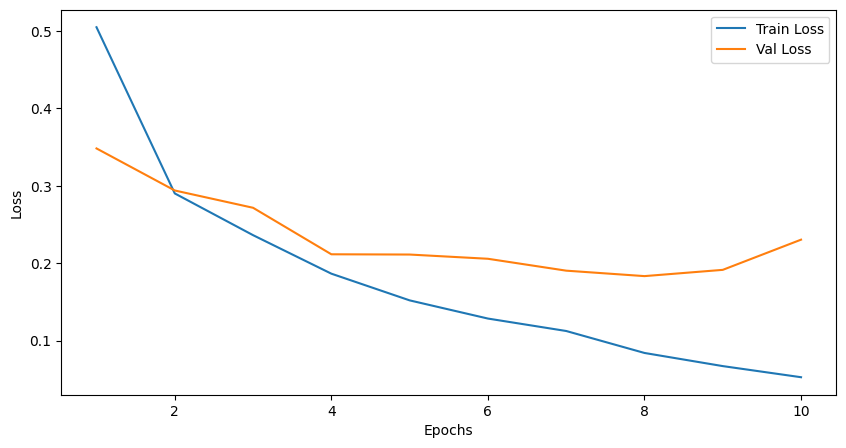

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, best_hyperparams["n_epochs"] + 1), train_losses, label="Train Loss")
plt.plot(range(1, best_hyperparams["n_epochs"] + 1), val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [47]:
# evaluation on test set
lstm_model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_iterator:
        sequences, lengths = batch.body
        labels = batch.label
        predictions = lstm_model(sequences, lengths).squeeze()
        test_preds.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


# convert to binary predictions
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# calculate metrics
accuracy = accuracy_score(test_labels, test_preds_binary)
precision = precision_score(test_labels, test_preds_binary)
recall = recall_score(test_labels, test_preds_binary)
f1 = f1_score(test_labels, test_preds_binary)
roc_auc = roc_auc_score(test_labels, test_preds)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall: {recall*100:.2f}%")
print(f"Test F1 Score: {f1*100:.2f}%")
print(f"Test ROC AUC: {roc_auc*100:.2f}%")

Test Accuracy: 94.12%
Test Precision: 92.48%
Test Recall: 95.82%
Test F1 Score: 94.12%
Test ROC AUC: 98.10%
